In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Models to use
#import lightgbm as lgb
import catboost as cb

# Importing the metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

# For measuring the training time taken during the fit process
from sklearn.model_selection import cross_val_score
import time

from hyperopt import hp, pyll, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval

In [3]:
import sys
sys.path.append('/gpfs/space/home/rabiichu/.conda/envs/avalanche-env/lib/python3.8/site-packages/xgboost/python-package')

In [3]:
from xgboost import XGBClassifier

In [4]:
df = pd.read_csv('higgs_cleaned.csv')
df.head()

,class,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,jet1b-tag,...,jet4eta,jet4phi,jet4b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818


In [5]:
X, y = df.drop('class', axis=1), df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1864)

# No fine-tuning

In [15]:
clf = XGBClassifier(random_state = 1864)
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
xgb_preds = clf.predict(X_test)

/gpfs/space/home/rabiichu/.conda/envs/avalanche-env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [16]:
print('Vanilla XGB Scores:')
print('Accuracy:', accuracy_score(y_test, xgb_preds))
print('ROC-AUC:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print('*'*60)
print('Detailed Report:')
print(classification_report(y_test, xgb_preds))

Vanilla XGB Scores:
Accuracy: 0.7187149413564508
ROC-AUC: 0.7968862029195385
************************************************************
Detailed Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.70      9342
           1       0.72      0.75      0.74     10268

    accuracy                           0.72     19610
   macro avg       0.72      0.72      0.72     19610
weighted avg       0.72      0.72      0.72     19610



# HPO with hyperopt

In [10]:
class objective_fn(object):
    
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials
    
    def ctb_clf(self, params):
        clf = cb.CatBoostClassifier(**params['clf_params'], verbose=False, task_type="GPU")
        acc = cross_val_score(clf, self.X_train, self.y_train, scoring='accuracy', fit_params=params['fit_params']).mean()
        return {"loss": -acc, "status": STATUS_OK}   
    
    def xgb_clf(self, params):
        clf = XGBClassifier(**params['clf_params'], verbose=False)
        y_train_int = self.y_train.astype(int) # since XGBoost label encoder is deprecated
        acc = cross_val_score(clf, self.X_train, self.y_train, scoring='accuracy', fit_params=params['fit_params']).mean()
        return {"loss": -acc, "status": STATUS_OK}   

# First result

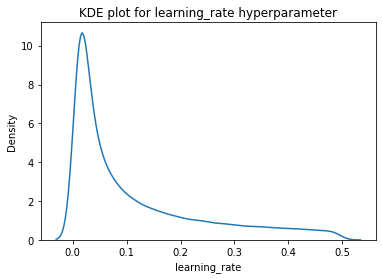

In [7]:
values = []
space = hp.loguniform('learning_rate', -5.0, -0.7)
for x in range(100000):
    values.append(pyll.stochastic.sample(space))
df = pd.DataFrame(values, columns=["learning_rate"])
sns.kdeplot(data=df, x='learning_rate')
plt.title('KDE plot for learning_rate hyperparameter')
plt.show()

In [11]:
# XGB search space
classifier_parameters = {
    'learning_rate': hp.loguniform('learning_rate', -5.0, -0.7),
    'max_depth': hp.choice('depth', [6, 7, 8, 9, 10]),  
    'subsample': hp.choice('subsample', [0.5, 0.75, 0.9, 1.]),
    'colsample_bytree': hp.choice('colsample_bytree', [0.25, 0.5, 0.75, 0.9, 1.]),
    'n_estimators': hp.choice('n_estimators', [50, 100, 200, 300, 500, 700, 1000]),
    'tree_method': 'gpu_hist',
    'verbosity': 0,
    'random_seed': 1864,
    'use_label_encoder': False
}

fit_parameters = {
#     'early_stopping_rounds': 30,
    'verbose': False
}

xgb_para = dict()
xgb_para['clf_params'] = classifier_parameters
xgb_para['fit_params'] = fit_parameters

In [13]:
obj = objective_fn(X_train, y_train)

trials = Trials()
start = time.time()
best = obj.process(fn_name='xgb_clf', space=xgb_para, trials=trials, algo=tpe.suggest, max_evals=350)
end = time.time()

total_time = end - start

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [5:18:52<00:00, 54.67s/trial, best loss: -0.731613092649692]


In [14]:
opt_params = space_eval(classifier_parameters, best[0])
opt_params

{'colsample_bytree': 0.9,
 'learning_rate': 0.019961510107543195,
 'max_depth': 9,
 'n_estimators': 1000,
 'random_seed': 1864,
 'subsample': 0.75,
 'tree_method': 'gpu_hist',
 'use_label_encoder': False,
 'verbosity': 0}

In [15]:
clf = XGBClassifier(
    **opt_params
)

clf.fit(X_train, y_train, **fit_parameters)
preds = clf.predict(X_test)
print(f'Test accuracy of the current optimal XGBoost model: {accuracy_score(y_test, preds)}')

Test accuracy of the current optimal XGBoost model: 0.7293727689954105


## Second result

In [12]:
# XGB search space
classifier_parameters = {
    'learning_rate': hp.loguniform('learning_rate', -5.0, -0.7),
    'max_depth': hp.choice('max_depth', [6, 7, 8, 9, 10]),  
    'subsample': hp.choice('subsample', [0.5, 0.75, 0.9, 1.]),
    'colsample_bytree': hp.choice('colsample_bytree', [0.5, 0.75, 0.9, 1.]),
    'colsample_bylevel': hp.choice('colsample_bylevel', [0.5, 0.75, 0.9, 1.]),
    'colsample_bynode': hp.choice('colsample_bynode', [0.5, 0.75, 0.9, 1.]),
    'n_estimators': hp.choice('n_estimators', [50, 100, 200, 300, 500, 700, 1000]),
    'min_child_weight': hp.choice('min_child_weight', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
    'tree_method': 'gpu_hist',
    'verbosity': 0,
    'random_seed': 1864,
    'use_label_encoder': False
}

fit_parameters = {
#     'early_stopping_rounds': 30,
    'verbose': False
}

xgb_para = dict()
xgb_para['clf_params'] = classifier_parameters
xgb_para['fit_params'] = fit_parameters

In [13]:
obj = objective_fn(X_train, y_train)

trials = Trials()
start = time.time()
best = obj.process(fn_name='xgb_clf', space=xgb_para, trials=trials, algo=tpe.suggest, max_evals=300)
end = time.time()

total_time = end - start

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [4:18:21<00:00, 51.67s/trial, best loss: -0.7313580955033557]


In [14]:
opt_params = space_eval(classifier_parameters, best[0])
opt_params

{'colsample_bylevel': 0.9,
 'colsample_bynode': 0.75,
 'colsample_bytree': 0.75,
 'learning_rate': 0.023094135915937453,
 'max_depth': 10,
 'min_child_weight': 2,
 'n_estimators': 700,
 'random_seed': 1864,
 'subsample': 0.9,
 'tree_method': 'gpu_hist',
 'use_label_encoder': False,
 'verbosity': 0}

In [15]:
clf = XGBClassifier(
    **opt_params
)

clf.fit(X_train, y_train, **fit_parameters)
preds = clf.predict(X_test)
print(f'Test accuracy of the current optimal XGBoost model: {accuracy_score(y_test, preds)}')

Test accuracy of the current optimal XGBoost model: 0.7291687914329423
